In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

In [3]:
path = "./germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
df['Rotate'] = 0

In [4]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,0
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,0
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,0
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,0
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,0


In [5]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.0
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,0.0
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,0.0
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,0.0
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,0.0
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,0.0
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,0.0
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,0.0


In [6]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 35
resize_y  = 35
num_of_channels = 3
directory = "./germany_dataset/"
Epochs=10
train_length = len(df)
CountConsider = 0

In [7]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[6]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    random.seed(42)
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        for j in range(len(classes[i])):
            row.append(classes[i][j])
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i].copy()
            f[0][8] = angle
            row.append(f[0])
    np.random.seed(42)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[6])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


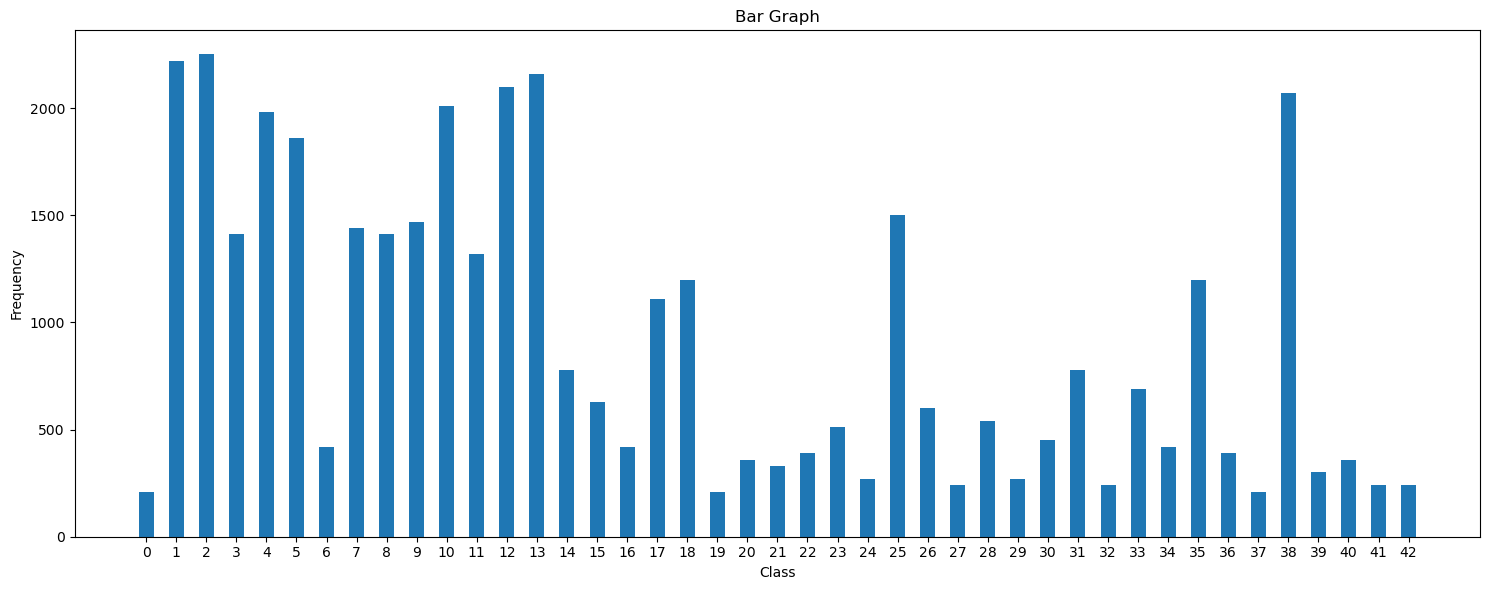

In [8]:
#Statistics of Data
viewStatistics(df)

In [9]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


Total number of images after Upsampling:  39209


Time taken to upsample images :  0.021535642941792808  min
Total Training Examples :  39209


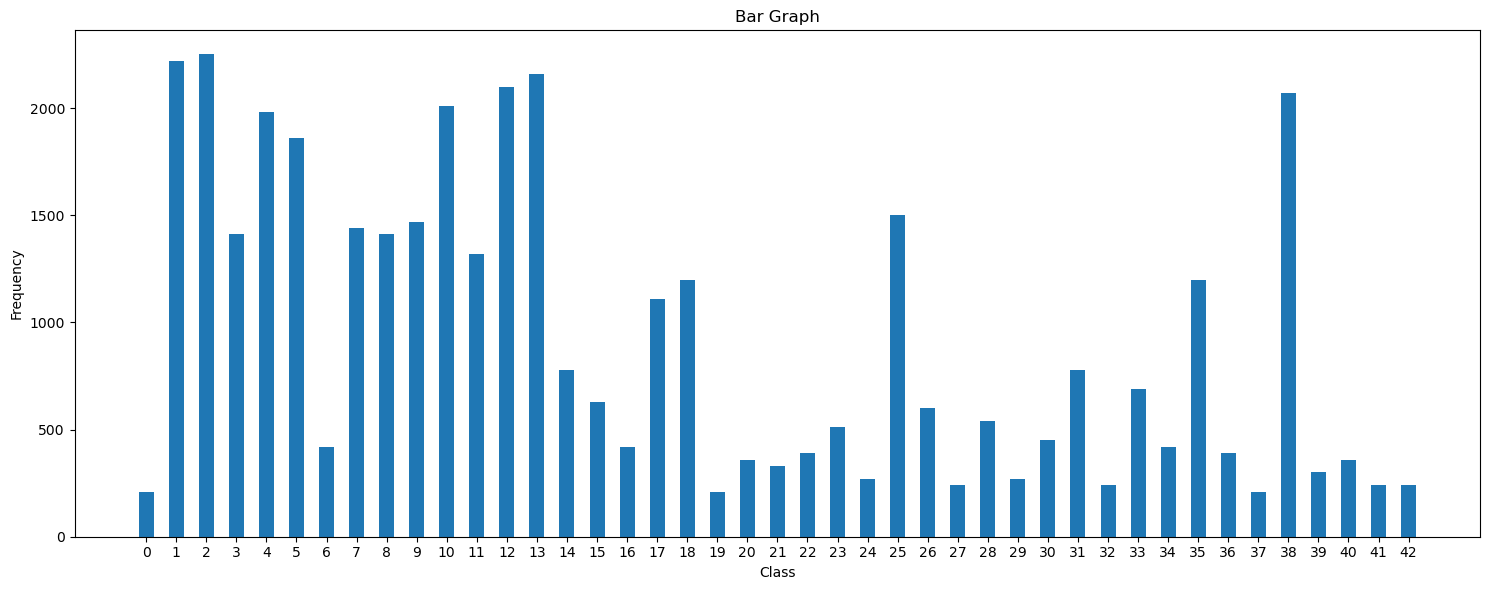

In [10]:
df = upSampleDataFrame(df,CountConsider)
viewStatistics(df)

In [11]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[7])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        img = img.rotate(val[8])
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [12]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = img.resize((self.resize_x,self.resize_y))
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[7],row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[8]))
        self.Y.append(int(row.iloc[6]))
        
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(df)):
            row = df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])]=want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

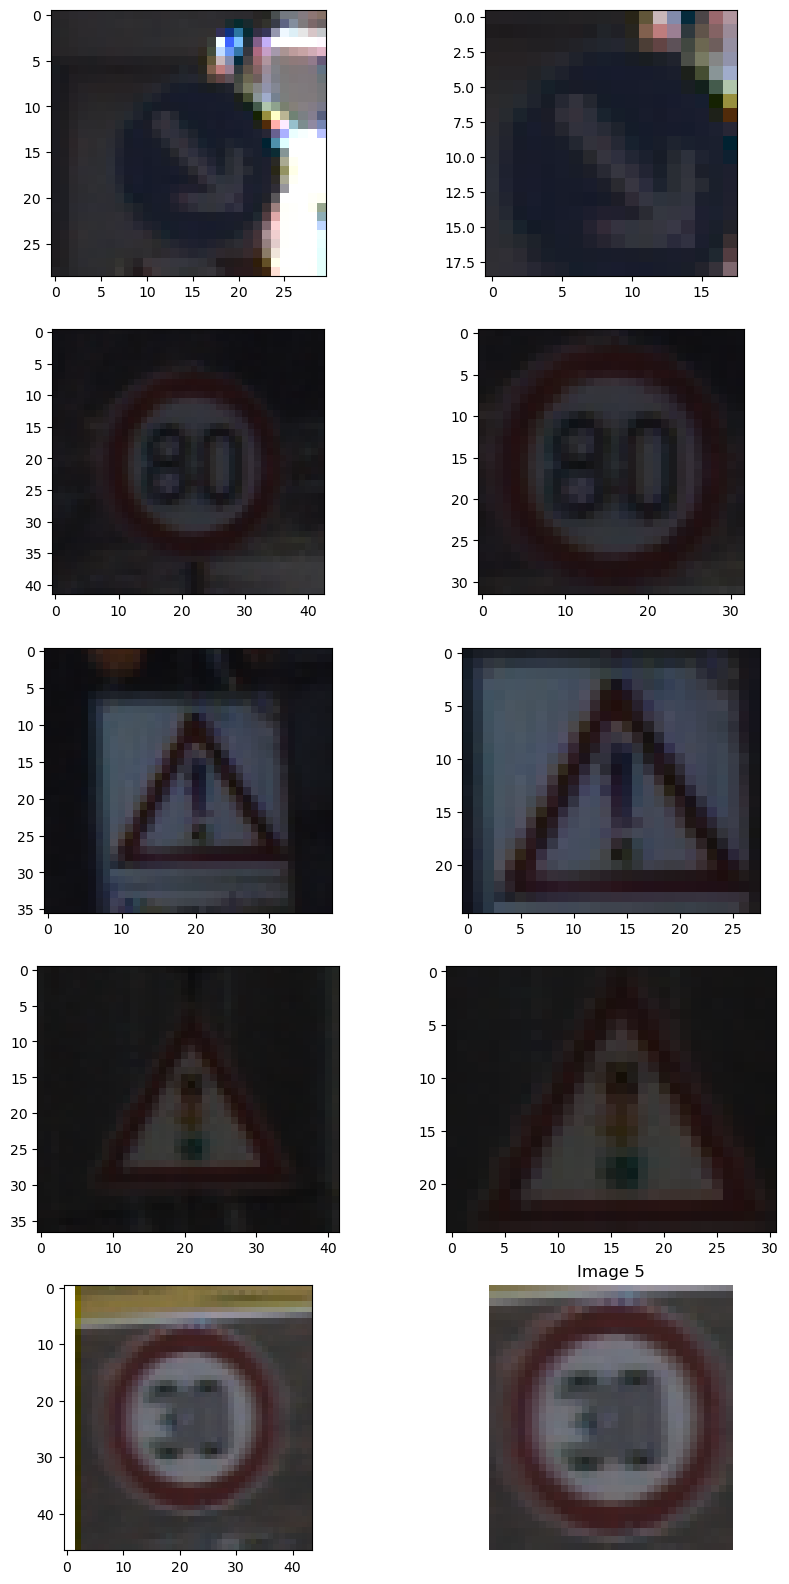

In [13]:
showExamples(df)

In [14]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data(40000)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  4.722105097770691  min


In [15]:
X_train = data.X
Y_train = data.Y

In [16]:
#Data_Augmentation
X_train = X_train/255.0

In [17]:
# conversion of Y_train into 2d array in order to feed CNN 
Temp = []
for i in range(len(Y_train)):
    row = [0]*num_of_classes
    row[Y_train[i]]=1
    Temp.append(np.array(row))
Y_train = np.array(Temp)

In [18]:
# Implementation of ANN
model = Sequential()
model.add(Flatten(input_shape=(resize_x, resize_y, num_of_channels)))
model.add(Dense(64, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3675)              0         
                                                                 
 dense (Dense)               (None, 64)                235264    
                                                                 
 dense_1 (Dense)             (None, 43)                2795      
                                                                 
Total params: 238059 (929.92 KB)
Trainable params: 238059 (929.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/10
858/858 [==============================] - 5s 4ms/step - loss: 2.2009 - accuracy: 0.4580 - val_loss: 1.3742 - val_accuracy: 0.6724
Epoch 2/10
858/858 [==============================] - 3s 3ms/step - loss: 1.1230 - accuracy: 0.7271 - val_loss: 0.9374 - val_accuracy: 0.7728
Epoch 3/10
858/858 [==============================] - 3s 3ms/step - loss: 0.8285 - accuracy: 0.8014 - val_loss: 0.7439 - val_accuracy: 0.8169
Epoch 4/10
858/858 [==============================] - 3s 3ms/step - loss: 0.6861 - accuracy: 0.8369 - val_loss: 0.6802 - val_accuracy: 0.8298
Epoch 5/10
858/858 [==============================] - 3s 3ms/step - loss: 0.6014 - accuracy: 0.8555 - val_loss: 0.5987 - val_accuracy: 0.8595
Epoch 6/10
858/858 [==============================] - 3s 3ms/step - loss: 0.5418 - accuracy: 0.8735 - val_loss: 0.5389 - val_accuracy: 0.8807
Epoch 7/10
858/858 [==============================] - 2s 3ms/step - loss: 0.4976 - accuracy: 0.8842 - val_loss: 0.4835 - val_accuracy: 0.8933
Epoch 

In [21]:
#Saving the model
model.save("ANN_Model")

INFO:tensorflow:Assets written to: ANN_Model\assets


INFO:tensorflow:Assets written to: ANN_Model\assets


In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

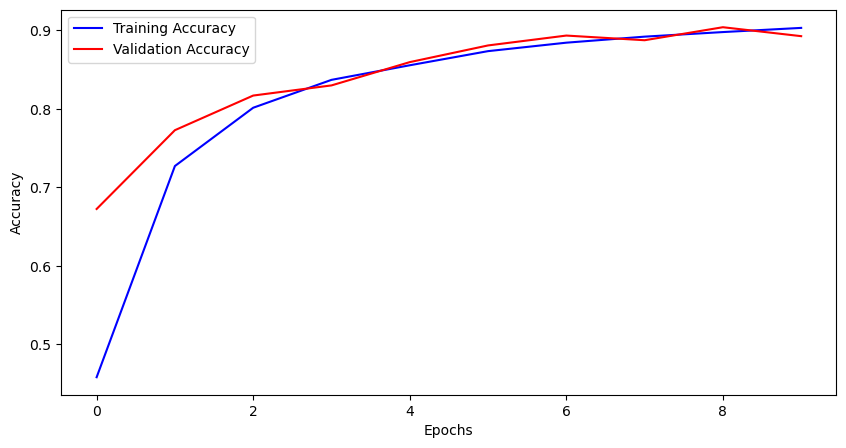

In [23]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

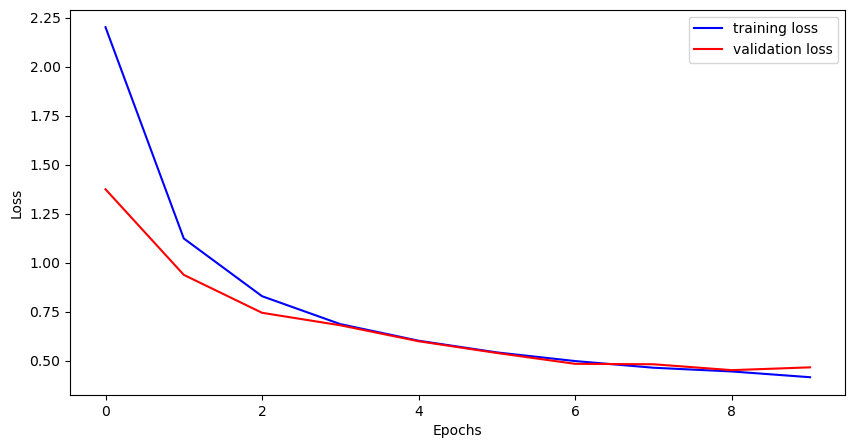

In [24]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [25]:
#Loading weights into CNN model
model = tf.keras.models.load_model("ANN_Model")

In [26]:
df_test = pd.read_csv("./germany_dataset/test.csv")
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test['Rotate']=0
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate
0,53,54,6,5,48,49,16,Test/00000.png,0
1,42,45,5,5,36,40,1,Test/00001.png,0
2,48,52,6,6,43,47,38,Test/00002.png,0
3,27,29,5,5,22,24,33,Test/00003.png,0
4,60,57,5,5,55,52,11,Test/00004.png,0


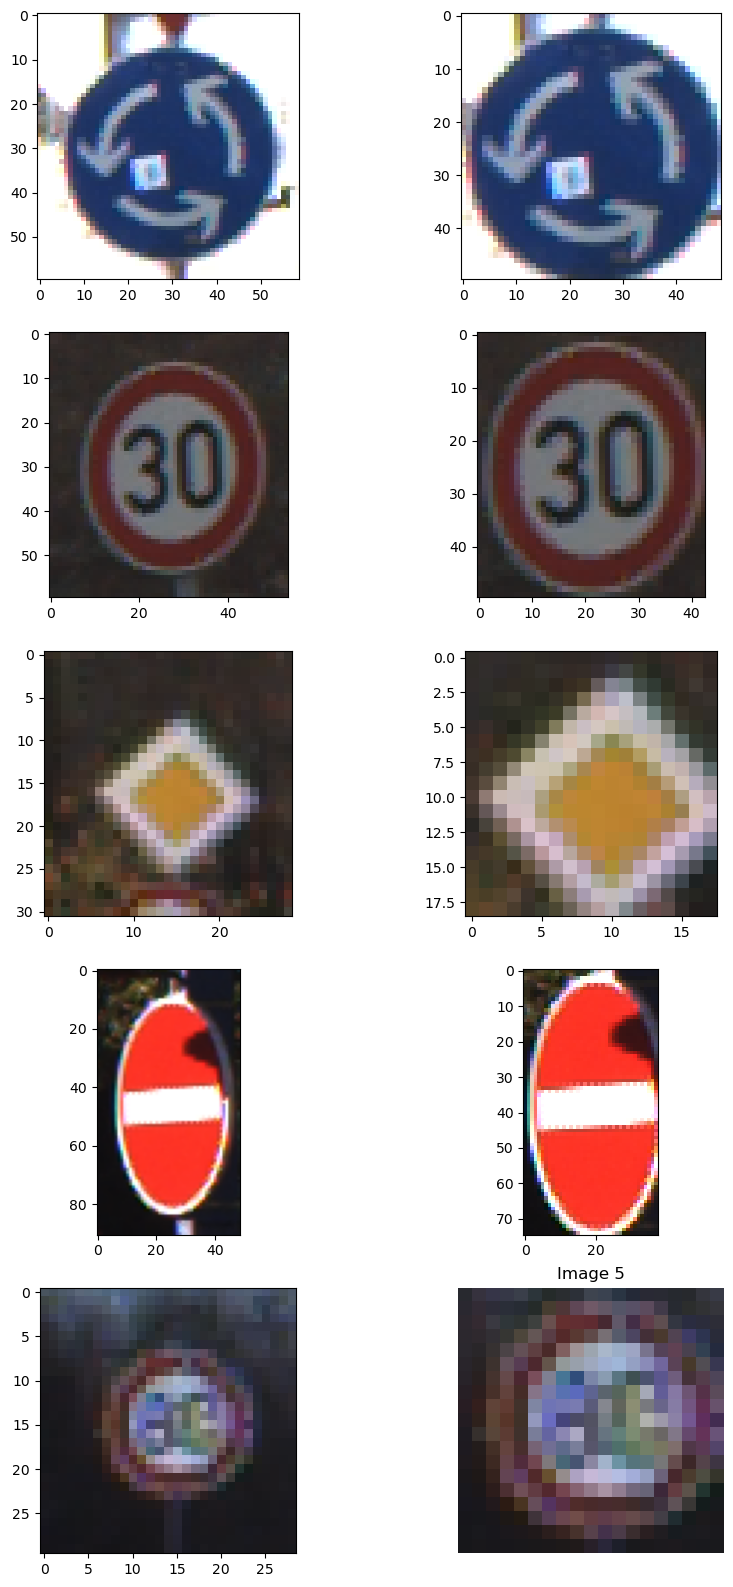

In [27]:
showExamples(df_test)

In [28]:
df_test = upSampleDataFrame(df_test,100)

Total number of images after Upsampling:  12940


Time taken to upsample images :  0.007508508364359538  min


In [29]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.00000,12940.000000,12940.000000
mean,50.296986,50.140108,5.984158,5.970479,44.665224,44.54289,15.826893,4.974961
std,24.893655,23.529186,1.530324,1.414397,23.597721,22.34248,12.097487,34.226134
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.00000,0.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.00000,5.000000,0.000000
50%,42.000000,43.000000,6.000000,6.000000,37.000000,38.00000,12.000000,0.000000
75%,58.000000,57.000000,6.000000,6.000000,52.000000,52.00000,25.000000,0.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.00000,42.000000,325.000000


In [30]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df,0,12940)

405/405 [==============================] - 1s 1ms/step


In [31]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  89.58268933539412

Confusion Matrix:
 [[ 52   6   0 ...   0   0   0]
 [  1 628  78 ...   0   0   0]
 [  0   2 697 ...   0   0   0]
 ...
 [  0   0   0 ... 102   0   0]
 [  0   1   0 ...   0  67   1]
 [  0   0   0 ...   0   0  72]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.96,0.85,0.90,61
1,1,0.97,0.82,0.89,763
2,2,0.84,0.93,0.88,751
3,3,0.93,0.86,0.90,466
4,4,0.94,0.86,0.90,672
5,5,0.85,0.85,0.85,629
6,6,0.95,0.93,0.94,120
7,7,0.76,0.91,0.83,444
8,8,0.83,0.89,0.86,510
9,9,0.95,0.90,0.92,481


Original Value :  2
1/1 [==============================] - 0s 30ms/step
Predicted Value :  2


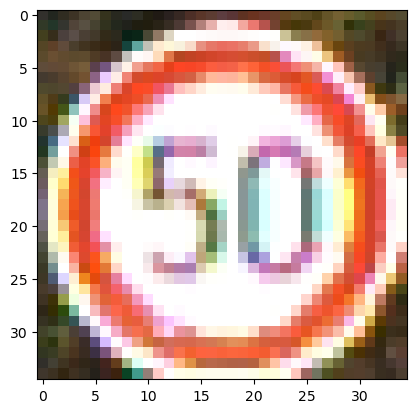

In [32]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[7])
img = img.crop((row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

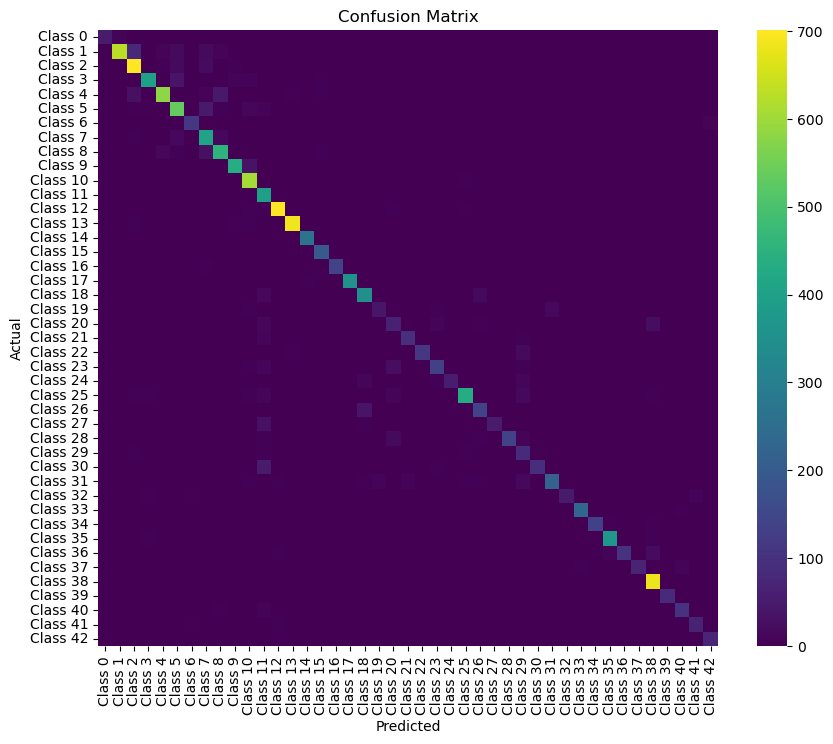

In [33]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()